<br></br>
<font size=6 face=雅黑>Topline笔记</font>
<br></br>
<font size=5 face=雅黑>1. 前言</font>
<br></br>
模型的理论部分可参考 Bert.ipynb 中的内容。其中，在此处所使用到的预训练模型为Bert的改进版——Roberta-base。它与Bert的区别在于：①Roberta在预训练的阶段中没有对下一句话进行预测（NSP）②采用了动态掩码 ③使用字符级和词级别表征的混合文本编码。<a href="https://arxiv.org/pdf/1907.11692.pdf">（对Roberta感兴趣的话，可以阅读一下Roberta论文）</a>

与常规的预训练模型接分类器不同，我对网络结构进行了更进一步的改进，具体细节如下：

在模型结构上使用了以下两个特征：
<center>
    特征1：MeanPooling(768维) -> fc(128维) 
<br></br>
    特征2：Last_hidden (768维) -> fc(128维)
</center>
<br></br>
其中，特征1指的是将Roberta所输出的全部序列分词的表征向量先进行一个平均池化再接一个全连接层(fc，Fully Connected Layer)；特征2指的是将Roberta的pooled_output接一个全连接层(fc，Fully Connected Layer)。（pooled_output = [CLS]的表征向量接入一个全连接层，再输入至Tanh激活函数）
  <br></br>
然后，将这两个特征进行加权并相加即可输进分类器进行训练。（在代码中，仅是将它们进行等权相加。后续当然也可以尝试分配不同的权重，看能否获得更好的性能）（Dropout层其实并不是一个必要项，可加可不加~）
<br></br>

最后，将训练好的模型用于推理测试集，并根据标签数目的反馈，对预测阈值进行调整。（后处理）
<br></br>
    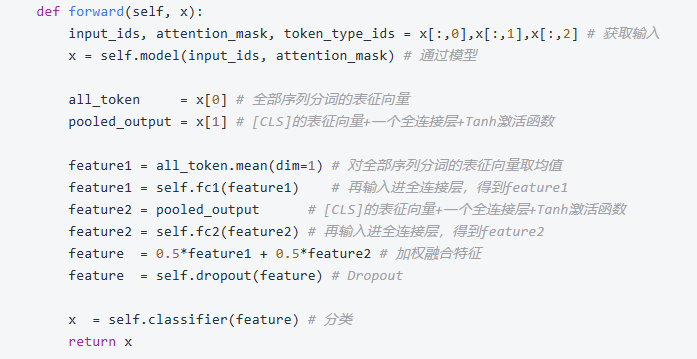
<br></br>
在代码部分中，主要分为四个模块：1.数据处理 2.模型训练 3.模型评估 4.测试集推理
<br></br>
以下是代码文件的目录结构：
<br></br>
    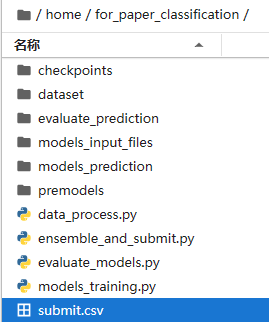
<br></br>
文件夹的命名含义：
<br></br>
checkpoints             -> 存放模型在训练阶段的临时权重
<br></br>
dataset                   -> 存放数据集，包含train.csv、testB.csv和testB_submit_exsample.csv文件
<br></br>
evaluate_prediction  -> 存放模型在评估阶段的临时文件（模型对验证集的推理概率文件）
<br></br>
models_input_files   -> 存放模型的输入文件
<br></br>
models_prediction   -> 存放模型对测试集的推理概率文件
<br></br>
premodels              -> 存放在线下载的预训练模型权重、config.json等文件
<br></br>
代码文件的命名含义：
<br></br>
data_process.py               -> 数据处理
<br></br>
models_training.py           -> 模型训练
<br></br>
evaluate_models.py          -> 模型评估
<br></br>
ensemble_and_submit.py  -> 推理测试集（其实这里也包括模型集成的部分，不过这里没用到）
<br></br>
以下介绍四个模块的代码及其功能：
<br></br>
<font size=5 face=雅黑>2. 模块一：数据处理</font>
<br></br>
data_process.py代码如下：

In [ ]:
from transformers import AutoTokenizer  # 导入AutoTokenizer类，用于文本分词
import pandas as pd  # 导入pandas库，用于处理数据表格
import numpy as np  # 导入numpy库，用于科学计算
from tqdm import tqdm  # 导入tqdm库，用于显示进度条
import torch  # 导入torch库，用于深度学习任务
from torch.nn.utils.rnn import pad_sequence  # 导入pad_sequence函数，用于填充序列，保证向量中各序列维度的大小一样

MAX_LENGTH = 128  # 定义最大序列长度为128

def get_train(model_name, model_dict):
    model_index = model_dict[model_name]  # 获取模型索引
    train = pd.read_csv('./dataset/train.csv')  # 从CSV文件中读取训练数据
    train['content'] = train['title'] + train['author'] + train['abstract']  # 将标题、作者和摘要拼接为训练内容
    tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=MAX_LENGTH, cache_dir=f'./premodels/{model_name}_saved')  # 实例化分词器对象
    # 通过分词器对训练数据进行分词，并获取输入ID、注意力掩码和标记类型ID（这个可有可无）
    input_ids_list, attention_mask_list, token_type_ids_list = [], [], []
    y_train = []  # 存储训练数据的标签
    
    for i in tqdm(range(len(train['content']))):  # 遍历训练数据
        sample = train['content'][i]  # 获取样本内容
        tokenized = tokenizer(sample, truncation='longest_first')  # 分词处理，使用最长优先方式截断
        input_ids, attention_mask = tokenized['input_ids'], tokenized['attention_mask']  # 获取输入ID和注意力掩码
        input_ids, attention_mask = torch.tensor(input_ids), torch.tensor(attention_mask)  # 转换为PyTorch张量
        try:
            token_type_ids = tokenized['token_type_ids']  # 获取标记类型ID
            token_type_ids = torch.tensor(token_type_ids)  # 转换为PyTorch张量
        except:
            token_type_ids = input_ids
        input_ids_list.append(input_ids)  # 将输入ID添加到列表中
        attention_mask_list.append(attention_mask)  # 将注意力掩码添加到列表中
        token_type_ids_list.append(token_type_ids)  # 将标记类型ID添加到列表中
        y_train.append(train['label'][i])  # 将训练数据的标签添加到列表中
    # 保存
    input_ids_tensor = pad_sequence(input_ids_list, batch_first=True, padding_value=0)  # 对输入ID进行填充，保证向量中各序列维度的大小一样，生成张量
    attention_mask_tensor = pad_sequence(attention_mask_list, batch_first=True, padding_value=0)  # 对注意力掩码进行填充，保证向量中各序列维度的大小一样，生成张量
    token_type_ids_tensor = pad_sequence(token_type_ids_list, batch_first=True, padding_value=0)  # 对标记类型ID进行填充，保证向量中各序列维度的大小一样，生成张量
    x_train = torch.stack([input_ids_tensor, attention_mask_tensor, token_type_ids_tensor], dim=1)  # 将输入张量堆叠为一个张量
    x_train = x_train.numpy()  # 转换为NumPy数组
    np.save(f'./models_input_files/x_train{model_index}.npy', x_train)  # 保存训练数据
    y_train = np.array(y_train)  # 将标签列表转换为NumPy数组
    np.save(f'./models_input_files/y_train{model_index}.npy', y_train)  # 保存标签数据
    
def get_test(model_name, model_dict):
    model_index = model_dict[model_name]  # 获取模型索引
    test = pd.read_csv('./dataset/testB.csv')  # 从CSV文件中读取测试数据
    test['content'] = test['title'] + ' ' + test['author'] + ' ' + test['abstract']  # 将标题、作者和摘要拼接为测试内容
    tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=MAX_LENGTH,cache_dir=f'./premodels/{model_name}_saved')  # 实例化分词器对象
    # 通过分词器对测试数据进行分词，并获取输入ID、注意力掩码和标记类型ID（可有可无）
    input_ids_list, attention_mask_list, token_type_ids_list = [], [], []
    
    for i in tqdm(range(len(test['content']))):  # 遍历测试数据
        sample = test['content'][i]  # 获取样本内容
        tokenized = tokenizer(sample, truncation='longest_first')  # 分词处理，使用最长优先方式截断
        input_ids, attention_mask = tokenized['input_ids'], tokenized['attention_mask']  # 获取输入ID和注意力掩码
        input_ids, attention_mask = torch.tensor(input_ids), torch.tensor(attention_mask)  # 转换为PyTorch张量
        try:
            token_type_ids = tokenized['token_type_ids']  # 获取标记类型ID
            token_type_ids = torch.tensor(token_type_ids)  # 转换为PyTorch张量
        except:
            token_type_ids = input_ids
        input_ids_list.append(input_ids)  # 将输入ID添加到列表中
        attention_mask_list.append(attention_mask)  # 将注意力掩码添加到列表中
        token_type_ids_list.append(token_type_ids)  # 将标记类型ID添加到列表中
    
    # 保存
    input_ids_tensor = pad_sequence(input_ids_list, batch_first=True, padding_value=0)  # 对输入ID进行填充，保证向量中各序列维度的大小一样，生成张量
    attention_mask_tensor = pad_sequence(attention_mask_list, batch_first=True, padding_value=0)  # 对注意力掩码进行填充，保证向量中各序列维度的大小一样，生成张量
    token_type_ids_tensor = pad_sequence(token_type_ids_list, batch_first=True, padding_value=0)  # 对标记类型ID进行填充，保证向量中各序列维度的大小一样，生成张量
    x_test = torch.stack([input_ids_tensor, attention_mask_tensor, token_type_ids_tensor], dim=1)  # 将输入张量堆叠为一个张量
    x_test = x_test.numpy()  # 转换为NumPy数组
    np.save(f'./models_input_files/x_test{model_index}.npy', x_test)  # 保存测试数据
    
def split_train(model_name, model_dict):
    # 处理样本内容
    model_index = model_dict[model_name]  # 获取模型索引
    train = np.load(f'./models_input_files/x_train{model_index}.npy')  # 加载训练数据
    state = np.random.get_state()  # 获取随机数状态，保证样本间的随机是可重复的
    np.random.shuffle(train)  # 随机打乱训练数据
    # 训练集:验证集 = 9 : 1
    val = train[int(train.shape[0] * 0.90):]  # 划分验证集
    train = train[:int(train.shape[0] * 0.90)]  # 划分训练集
    np.save(f'./models_input_files/x_train{model_index}.npy', train)  # 保存训练集
    np.save(f'./models_input_files/x_val{model_index}.npy', val)  # 保存验证集
    train = np.load(f'./models_input_files/y_train{model_index}.npy')  # 加载标签数据
    
    # 处理样本标签
    np.random.set_state(state)  # 恢复随机数状态，让样本标签的随机可重复
    np.random.shuffle(train)  # 随机打乱标签数据
    # 训练集:验证集 = 9 : 1
    val = train[int(train.shape[0] * 0.90):]  # 划分验证集
    train = train[:int(train.shape[0] * 0.90)]  # 划分训练集
    np.save(f'./models_input_files/y_train{model_index}.npy', train)  # 保存训练集标签
    np.save(f'./models_input_files/y_val{model_index}.npy', val)  # 保存验证集标签
    
    print('split done.')
           
if __name__ == '__main__':
    model_dict = {'xlm-roberta-base':1, 'roberta-base':2, 'bert-base-uncased':3, 
                  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext':4, 'dmis-lab/biobert-base-cased-v1.2':5, 'marieke93/MiniLM-evidence-types':6,
                  'microsoft/MiniLM-L12-H384-uncased':7, 'cambridgeltl/SapBERT-from-PubMedBERT-fulltext':8,'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract':9,
                  'microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract':10}
    model_name = 'roberta-base'
    get_train(model_name, model_dict)
    get_test(model_name, model_dict)
    split_train(model_name, model_dict)


<br></br>
<font size=5 face=雅黑>3. 模块二：模型训练</font>
<br></br>
models_training.py代码如下：

In [ ]:
# 导入需要的库
import numpy as np  # 导入numpy库，用于科学计算
import torch  # 导入torch库，用于深度学习任务
import torch.nn as nn  # 导入torch.nn模块，用于神经网络相关操作
from sklearn import metrics  # 导入sklearn库，用于评估指标计算
import os    # 导入os库，用于操作系统相关功能
import time  # 导入time库，用于时间相关操作
from transformers import AutoModel, AutoConfig  # 导入AutoModel和AutoConfig类，用于加载预训练模型
from tqdm import tqdm  # 导入tqdm库，用于显示进度条

# 超参数类 - 可修改的所有超参数都在这里~
class opt:
    seed               = 42 # 随机种子
    batch_size         = 16 # 批处理大小
    set_epoch          = 5  # 训练轮数 
    early_stop         = 5  # 提前停止epoch数
    learning_rate      = 1e-5 # 学习率
    weight_decay       = 2e-6 # 权重衰减,L2正则化
    device             = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 选择设备,GPU或CPU
    gpu_num            = 1 # GPU个数
    use_BCE            = False # 是否使用BCE损失函数
    models             = ['xlm-roberta-base', 'roberta-base', 'bert-base-uncased',  
                          'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext', 'dmis-lab/biobert-base-cased-v1.2', 'marieke93/MiniLM-evidence-types',  
                          'microsoft/MiniLM-L12-H384-uncased','cambridgeltl/SapBERT-from-PubMedBERT-fulltext', 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract',
                          'microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract'] # 模型名称列表
    model_index        = 2 # 根据上面选择使用的模型，这里填对应的模型索引
    model_name         = models[model_index-1] # 使用的模型名称
    continue_train     = False # 是否继续训练
    show_val           = False # 是否显示验证过程

# 定义模型
class MODEL(nn.Module):
    def __init__(self, model_index):
        super(MODEL, self).__init__()
        # 若是第一次下载权重，则下载至同级目录的./premodels/内，以防占主目录的存储空间
        self.model = AutoModel.from_pretrained(opt.models[model_index-1], cache_dir='./premodels/'+opt.models[model_index-1]+'_saved', from_tf=False) # 加载预训练语言模型
        # 加载模型配置，可以直接获得模型最后一层的维度，而不需要手动修改
        config = AutoConfig.from_pretrained(opt.models[model_index-1], cache_dir='./premodels/'+opt.models[model_index-1]+'_saved') # 获取配置
        last_dim = config.hidden_size # 最后一层的维度
        if opt.use_BCE:out_size = 1 # 损失函数如果使用BCE,则输出大小为1
        else          :out_size = 2 # 否则则使用CE,输出大小为2
        feature_size = 128 # 设置特征的维度大小
        self.fc1 = nn.Linear(last_dim, feature_size) # 全连接层1
        self.fc2 = nn.Linear(last_dim, feature_size) # 全连接层2
        self.classifier = nn.Linear(feature_size, out_size) # 分类器
        self.dropout = nn.Dropout(0.3) # Dropout层

            
    def forward(self, x):
        input_ids, attention_mask, token_type_ids = x[:,0],x[:,1],x[:,2] # 获取输入
        x = self.model(input_ids, attention_mask) # 通过模型
        
        all_token     = x[0] # 全部序列分词的表征向量
        pooled_output = x[1] # [CLS]的表征向量+一个全连接层+Tanh激活函数

        feature1 = all_token.mean(dim=1) # 对全部序列分词的表征向量取均值
        feature1 = self.fc1(feature1)    # 再输入进全连接层，得到feature1
        feature2 = pooled_output      # [CLS]的表征向量+一个全连接层+Tanh激活函数
        feature2 = self.fc2(feature2) # 再输入进全连接层，得到feature2
        feature  = 0.5*feature1 + 0.5*feature2 # 加权融合特征
        feature  = self.dropout(feature) # Dropout

        x  = self.classifier(feature) # 分类
        return x

# 数据加载
def load_data():
    train_data_path     = f'models_input_files/x_train{model_index}.npy' # 训练集输入路径
    train_label_path    = f'models_input_files/y_train{model_index}.npy' # 训练集标签路径
    val_data_path       = f'models_input_files/x_val{model_index}.npy'   # 验证集输入路径
    val_label_path      = f'models_input_files/y_val{model_index}.npy'   # 验证集标签路径
    test_data_path      = f'models_input_files/x_test{model_index}.npy'  # 测试集输入路径
    
    train_data          = torch.tensor(np.load(train_data_path  , allow_pickle=True).tolist()) # 载入训练集数据
    train_label         = torch.tensor(np.load(train_label_path  , allow_pickle=True).tolist()).long() # 载入训练集标签  
    val_data            = torch.tensor(np.load(val_data_path  , allow_pickle=True).tolist()) # 载入验证集数据
    val_label           = torch.tensor(np.load(val_label_path  , allow_pickle=True).tolist()).long() # 载入验证集标签
    test_data           = torch.tensor(np.load(test_data_path  , allow_pickle=True).tolist()) # 载入测试集数据

    train_dataset       = torch.utils.data.TensorDataset(train_data  , train_label) # 构造训练集Dataset
    val_dataset         = torch.utils.data.TensorDataset(val_data  , val_label) # 构造验证集Dataset
    test_dataset        = torch.utils.data.TensorDataset(test_data) # 构造测试集Dataset
    
    return train_dataset, val_dataset, test_dataset # 返回数据集

# 模型预训练
def model_pretrain(model_index, train_loader, val_loader):
    # 超参数设置
    set_epoch          = opt.set_epoch  # 训练轮数
    early_stop         = opt.early_stop # 提前停止epoch数
    learning_rate      = opt.learning_rate # 学习率
    weight_decay       = opt.weight_decay  # 权重衰减
    device             = opt.device  # 设备 
    gpu_num            = opt.gpu_num # GPU个数
    continue_train     = opt.continue_train # 是否继续训练
    model_save_dir     = 'checkpoints' # 模型保存路径
    
    # 是否要继续训练，若是，则加载模型进行训练；若否，则跳过训练，直接对测试集进行推理
    if not continue_train:
        # 判断最佳模型是否已经存在,若存在则直接读取,若不存在则进行训练
        if os.path.exists(f'checkpoints/best_model{model_index}.pth'): 
            best_model = MODEL(model_index)
            best_model.load_state_dict(torch.load(f'checkpoints/best_model{model_index}.pth')) # 加载模型
            return best_model
        else:
            pass
            

    # 模型初始化
    model = MODEL(model_index).to(device) 
    if continue_train:
        model.load_state_dict(torch.load(f'checkpoints/best_model{model_index}.pth')) # 继续训练加载模型

    # 优化器初始化
    if device    != 'cpu' and gpu_num > 1:  # 多张显卡
        optimizer = torch.optim.AdamW(model.module.parameters(), lr=learning_rate, weight_decay=weight_decay)
        optimizer = torch.nn.DataParallel(optimizer, device_ids=list(range(gpu_num))) # 多GPU
    else: # 单张显卡
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # 单GPU
    
    # 损失函数初始化
    if opt.use_BCE:
        loss_func = nn.BCEWithLogitsLoss() # BCE损失
    else:
        loss_func = nn.CrossEntropyLoss() # 交叉熵损失（CE）

    # 模型训练
    best_epoch         = 0 # 最佳epoch
    best_train_loss    = 100000 # 最佳训练损失
    train_acc_list     = [] # 训练准确率列表
    train_loss_list    = [] # 训练损失列表
    val_acc_list       = [] # 验证准确率列表 
    val_loss_list      = [] # 验证损失列表
    start_time         = time.time() # 训练开始时间

    for epoch in range(set_epoch): # 轮数
        model.train() # 模型切换到训练模式
        train_loss = 0 # 训练损失
        train_acc = 0 # 训练准确率
        for x, y in tqdm(train_loader): # 遍历训练集
            # 训练前先将数据放到GPU上
            x        = x.to(device)
            y        = y.to(device)
            outputs  = model(x) # 前向传播
            
            if opt.use_BCE: # BCE损失
                loss = loss_func(outputs, y.float().unsqueeze(1)) 
            else: # 交叉熵损失
                loss = loss_func(outputs, y)
            train_loss += loss.item() # 累加训练损失
            optimizer.zero_grad() # 清空梯度
            loss.backward() # 反向传播

            if device != 'cpu' and gpu_num > 1: # 多GPU更新
                optimizer.module.step()  
            else:
                optimizer.step() # 单GPU更新
            
            if not opt.use_BCE: # 非BCE损失
                _, predicted = torch.max(outputs.data, 1) # 预测结果
            else:
                predicted = (outputs > 0.5).int() # 预测结果
                predicted = predicted.squeeze(1) 
            train_acc   += (predicted == y).sum().item() # 计算训练准确率
            
        average_mode = 'binary'
        train_f1     = metrics.f1_score(y.cpu(), predicted.cpu(), average=average_mode) # 计算F1
        train_pre    = metrics.precision_score(y.cpu(), predicted.cpu(), average=average_mode) # 计算精确率
        train_recall = metrics.recall_score(y.cpu(), predicted.cpu(), average=average_mode) # 计算召回率


        train_loss /= len(train_loader) # 平均所有步数的训练损失作为一个epoch的训练损失
        train_acc  /= len(train_loader.dataset) # 平均所有步数训练准确率作为一个epoch的准确率
        train_acc_list.append(train_acc)   # 添加训练准确率
        train_loss_list.append(train_loss) # 添加训练损失

        print('-'*50)
        print('Epoch [{}/{}]\n Train Loss: {:.4f}, Train Acc: {:.4f}'.format(epoch + 1, set_epoch, train_loss, train_acc))
        print('Train-f1: {:.4f}, Train-precision: {:.4f} Train-recall: {:.4f}'.format(train_f1, train_pre, train_recall))

        if opt.show_val: # 显示验证过程
            # 验证
            model.eval() # 模型切换到评估模式
            val_loss = 0 # 验证损失
            val_acc = 0 # 验证准确率
    
            for x, y in tqdm(val_loader): # 遍历验证集
                # 训练前先将数据放到GPU上
                x = x.to(device) 
                y = y.to(device)
                outputs = model(x) # 前向传播
                if opt.use_BCE: # BCE损失
                    loss = loss_func(outputs, y.float().unsqueeze(1))
                else: # 交叉熵损失  
                    loss = loss_func(outputs, y)
                
                val_loss += loss.item() # 累加验证损失
                if not opt.use_BCE: # 非BCE损失
                    _, predicted = torch.max(outputs.data, 1) 
                else:
                    predicted = (outputs > 0.5).int() # 预测结果
                    predicted = predicted.squeeze(1)
                val_acc += (predicted == y).sum().item() # 计算验证准确率
    
            val_f1     = metrics.f1_score(y.cpu(), predicted.cpu(), average=average_mode) # 计算F1
            val_pre    = metrics.precision_score(y.cpu(), predicted.cpu(), average=average_mode) # 计算精确率
            val_recall = metrics.recall_score(y.cpu(), predicted.cpu(), average=average_mode) # 计算召回率
    
            val_loss /= len(val_loader) # 平均验证损失
            val_acc /= len(val_loader.dataset) # 平均验证准确率
            val_acc_list.append(val_acc)   # 添加验证准确率
            val_loss_list.append(val_loss) # 添加验证损失
            print('\nVal Loss: {:.4f}, Val Acc: {:.4f}'.format(val_loss, val_acc))
            print('Val-f1: {:.4f}, Val-precision: {:.4f} Val-recall: {:.4f}'.format(val_f1, val_pre, val_recall))

        if train_loss < best_train_loss: # 更新最佳训练损失
            best_train_loss = train_loss
            best_epoch = epoch + 1
            if device == 'cuda' and gpu_num > 1: # 多GPU保存模型
                torch.save(model.module.state_dict(), f'{model_save_dir}/best_model{model_index}.pth')
            else:
                torch.save(model.state_dict(), f'{model_save_dir}/best_model{model_index}.pth') # 单GPU保存模型
        
        # 提前停止判断
        if epoch+1 - best_epoch == early_stop:  
            print(f'{early_stop} epochs later, the loss of the validation set no longer continues to decrease, so the training is stopped early.')
            end_time = time.time()
            print(f'Total time is {end_time - start_time}s.')
            break

    best_model = MODEL(model_index) # 初始化最佳模型
    best_model.load_state_dict(torch.load(f'checkpoints/best_model{model_index}.pth')) # 加载模型参数
    return best_model # 返回最佳模型

# 模型推理
def model_predict(model, model_index, test_loader):
    device = 'cuda'
    model.to(device) # 模型到GPU
    model.eval()  # 切换到评估模式

    test_outputs = None
    with torch.no_grad():  # 禁用梯度计算
        for i, data in enumerate(tqdm(test_loader)):
            data = data[0].to(device) # 测试数据到GPU
            outputs = model(data) # 前向传播
            if i == 0: 
                test_outputs = outputs # 第一个batch直接赋值
            else:
                test_outputs = torch.cat([test_outputs, outputs], dim=0) # 其余batch拼接

            del data, outputs  # 释放不再需要的Tensor

    # 保存预测结果    
    if not opt.use_BCE: 
        test_outputs = torch.softmax(test_outputs, dim=1) # 转换为概率
    torch.save(test_outputs, f'./models_prediction/{model_index}_prob.pth') # 保存概率

def run(model_index):
    # 固定随机种子
    seed = opt.seed  
    torch.seed = seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

    train_dataset, val_dataset, test_dataset = load_data() # 加载数据集
    # 打印数据集信息
    print('-数据集信息:')
    print(f'-训练集样本数:{len(train_dataset)},测试集样本数:{len(test_dataset)}')
    train_labels = len(set(train_dataset.tensors[1].numpy()))
    # 查看训练样本类别均衡状况
    print(f'-训练集的标签种类个数为:{train_labels}') 
    numbers = [0] * train_labels
    for i in train_dataset.tensors[1].numpy():
        numbers[i] += 1
    print(f'-训练集各种类样本的个数:')
    for i in range(train_labels):
        print(f'-{i}的样本个数为:{numbers[i]}')

    batch_size   = opt.batch_size # 批处理大小
    # 构建DataLoader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
    val_loader   = torch.utils.data.DataLoader(dataset=val_dataset,   batch_size=batch_size, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

    best_model   = model_pretrain(model_index, train_loader, val_loader)

    # 使用验证集评估模型
    model_predict(best_model, model_index, test_loader) # 模型推理

if __name__ == '__main__':
    model_index = opt.model_index # 获取模型索引
    run(model_index) # 运行程序

<br></br>
<font size=5 face=雅黑>4. 模块三：评估模型</font>
<br></br>
evaluate_models.py 代码如下：

In [ ]:
import torch  # 导入torch库，用于深度学习任务
import pandas as pd  # 导入pandas库，用于处理数据表格
from models_training import MODEL  # 从本地文件models_training.py中导入MODEL类
import torch  # 导入torch库，用于深度学习任务
from tqdm import tqdm  # 导入tqdm库，用于显示进度条
from sklearn.metrics import classification_report  # 从sklearn.metrics模块导入classification_report函数，用于输出分类报告，看各标签的F1值
import numpy as np  # 导入numpy库，用于科学计算

# 推理
def inference(model_indexs, use_BCE):
    device = 'cuda'  # 设备选择为cuda
    for model_index in model_indexs:
        # 加载模型
        model = MODEL(model_index).to(device)  # 创建MODEL类的实例，并将模型移至设备(device)
        model.load_state_dict(torch.load(f'checkpoints/best_model{model_index}.pth'))  # 加载模型的权重参数
        model.eval()  # 切换到评估模式
        # 加载val数据
        val_data_path = f'models_input_files/x_val{model_index}.npy'  # val数据的路径
        val_data = torch.tensor(np.load(val_data_path, allow_pickle=True).tolist())  # 加载val数据，并转换为Tensor格式
        val_dataset = torch.utils.data.TensorDataset(val_data)  # 创建val数据集
        val_loader  = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)  # 创建val数据的数据加载器
        val_outputs = None  # 初始化val_outputs变量
        with torch.no_grad():  # 禁用梯度计算
            for i, data in enumerate(tqdm(val_loader)):  # 遍历val_loader，显示进度条
                data = data[0].to(device)  # 将数据移至GPU
                outputs = model(data)  # 模型推理，获取输出
                if i == 0:
                    val_outputs = outputs  # 若为第一次迭代，直接赋值给val_outputs
                else:
                    val_outputs = torch.cat([val_outputs, outputs], dim=0)  # 否则在dim=0上拼接val_outputs和outputs

                del data, outputs  # 释放不再需要的Tensor对象

        # 输出预测概率
        if not use_BCE:
            val_outputs = torch.softmax(val_outputs, dim=1)  # 对val_outputs进行softmax操作
        torch.save(val_outputs, f'evaluate_prediction/{model_index}_prob.pth')  # 保存预测概率结果


def run(model_indexs, use_BCE):
    # 读取所有的model_prob.pth，并全加在一起
    avg_pred = None  # 初始化avg_pred变量
    for i in model_indexs:
        pred = torch.load(f'evaluate_prediction/{i}_prob.pth').data  # 加载预测概率结果
        if use_BCE:
            # 选取大于0.5的作为预测结果
            pred = (pred > 0.5).int()  # 将大于0.5的值转换为整数（0或1）
            pred = pred.reshape(-1)  # 将预测结果进行形状重塑
        else:
            # 选取最大的概率作为预测结果
            pred = torch.argmax(pred, dim=1)  # 获取最大概率的索引作为预测结果
        pred = pred.cpu().numpy()  # 将预测结果转移到CPU上，并转换为NumPy数组

        # to_evaluate
        # 读取真实标签
        val_label_path = f'models_input_files/y_val{i}.npy'  # 真实标签的路径
        y_true = np.load(val_label_path)  # 加载真实标签
        # 分类报告
        print(f'model_index = {i}:')
        print(classification_report(y_true, pred, digits=4))  # 打印分类报告，包括精确度、召回率等指标

        zero_acc = 0; one_acc = 0 # 初始化0类和1类的准确率
        zero_num = 0; one_num= 0  # 初始化0类和1类的样本数量
        for i in range(pred.shape[0]):
            if y_true[i] == 0:
                zero_num += 1  # 统计0类的样本数量
            elif y_true[i] == 1:
                one_num += 1  # 统计1类的样本数量
            if pred[i] == y_true[i]:
                if pred[i] == 0:
                    zero_acc += 1  # 统计0类的正确预测数量
                elif pred[i] == 1:
                    one_acc += 1  # 统计1类的正确预测数量

        zero = np.sum(pred == 0) / pred.shape[0]  # 计算预测为0类的样本占比
        zero_acc /= zero_num  # 计算0类的正确率
        print(f'预测0类占比：{zero}  0类正确率：{zero_acc}')
        one = np.sum(pred == 1) / pred.shape[0]  # 计算预测为1类的样本占比
        one_acc /= one_num  # 计算1类的正确率
        print(f'预测1类占比：{one}  1类正确率：{one_acc}')
        print('-' * 80)


if __name__ == '__main__':
    use_BCE = False  # 是否使用BCE损失函数的标志，这里我只用交叉熵CE，所以是False
    inference([2], use_BCE=use_BCE)  # 进行推理，传入模型索引和use_BCE标志
    model_indexs = [2]  # 模型索引列表
    run(model_indexs, use_BCE=use_BCE)  # 进行运行，传入模型索引和use_BCE标志

<br></br>
<font size=5 face=雅黑>5. 模块四：测试集推理</font>
<br></br>
ensemble_and_submit.py 代码如下：

In [ ]:
import torch
import pandas as pd
import warnings # 过滤警告
warnings.filterwarnings('ignore')

def run(model_indexs, use_BCE):
    # 记录模型数量
    model_num = len(model_indexs)
    # 读取所有的model_prob.pth，并全加在一起
    for i in model_indexs:
        # 加载模型在训练完成后对测试集推理所得的预测文件
        pred = torch.load(f'./models_prediction/{i}_prob.pth', map_location='cpu').data
        # 这里的操作是将每个模型对测试集推理的概率全加在一起
        if i == model_indexs[0]:
            avg_pred = pred
        else:
            avg_pred += pred
        
    # 取平均
    avg_pred /= model_num # 使用全加在一起的预测概率除以模型数量

    if use_BCE:
        # 选取概率大于0.5的作为预测结果
        pred = (avg_pred > 0.5).int()
        pred = pred.reshape(-1)
    else:
        # 后处理 - 根据标签数目的反馈，对预测阈值进行调整
        pred[:, 0][pred[:, 0]>0.001] = 1
        pred[:, 1][pred[:, 1]>0.999] = 1.2
        # 选取最大的概率作为预测结果
        pred = torch.argmax(avg_pred, dim=1)
    pred = pred.cpu().numpy()

    # to_submit
    # 读取test.csv文件
    test = pd.read_csv('./dataset/testB_submit_exsample.csv')

    # 开始写入预测结果
    for i in range(len(pred)):
        test['label'][i] = pred[i]

    print(test['label'].value_counts())
    # 保存为提交文件
    test.to_csv(f'submit.csv',index=False)

if __name__ == '__main__':
    run([2], use_BCE=False)
    # run([1,2,3,4,5,6,7,8,9,10], use_BCE=False)


<br></br>
<font size=5 face=雅黑>6. 运行代码</font>
<br></br>
运行步骤：
<br></br>
data_process.py -> models_training.py -> ensemble_and_submit.py
<br></br>
运行完成后便可得到模型对测试集推理的结果